# Introduction

In times of disaster, it is crucial to have accurate and timely information. Social medi platforms can be useful tools in time of disaster to provide real-time data. In this project, 'Natural Language Processing with Disaster Tweets', we are tasked with building a Natural Language Processing model that predicts whether a Tweet is about a real disaster or not. We have a dataset consisting of 10,000 tweets that were hand classified as being related to a real disasster or not. 

The train dataset contains four columns: id, keyword, location, text, and target. 

We are given ~7500 Tweets to train on and ~3000 for testing. 

The data we are given consists of a test.csv file containing the id, keyword, location, and text, and target for each Tweet. 

We are also given a test.csv file to test on containing an id, keyword, location, and text of the Tweet. 

We are also provided a sample submission csv file to inform us of the structure of our submission file for the competition. 

Our goal is to predict the target, (1) if the Tweet was about a real disasster, (0) otherwise.

This is a natural language processing task. Natural language processing is a wide field at the intersection of computer science, artificial intelligence, and linguistics where the goal is to enable computers to understand, interpret, generate, and resspond to human language. Natural language processsing tasks are varied; including sentiment analysis, named entity recognition, and classification tasks. We will usse some of these techniques to clean the data and build a model to predict whether a Tweet is related to a real disaster or not.

# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_dataset = r'C:\Users\josea\OneDrive\Desktop\NLPDisasterTweets\train.csv'
df = pd.read_csv(train_dataset)

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


Given that we have 7,613 Tweets, we can immediately see that a large percentage of the locations are null.

In [3]:
print(df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [4]:
print(df.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


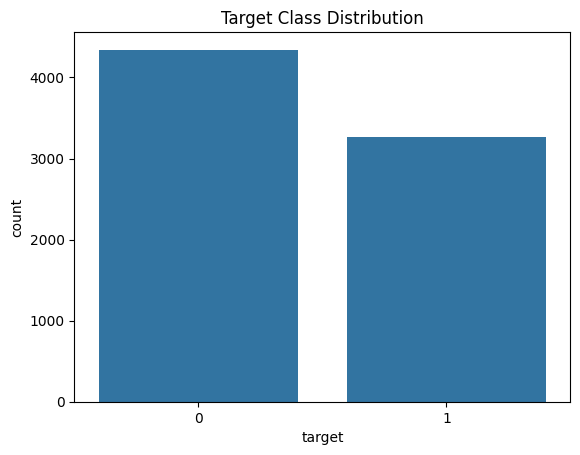

In [5]:
sns.countplot(x='target', data=df)
plt.title('Target Class Distribution')
plt.show()

The train dataset has a great disstribution of Disaster and non-disaster Tweets to work with. Given the large number of samples and the fairly even distribution, we will most likely not need to augment the data in any way, i.e. enhancing the dataset by bringing in more Tweets that we hand classify. With the distribution that we have, there is enough data to create a well performing model without more Tweets. 

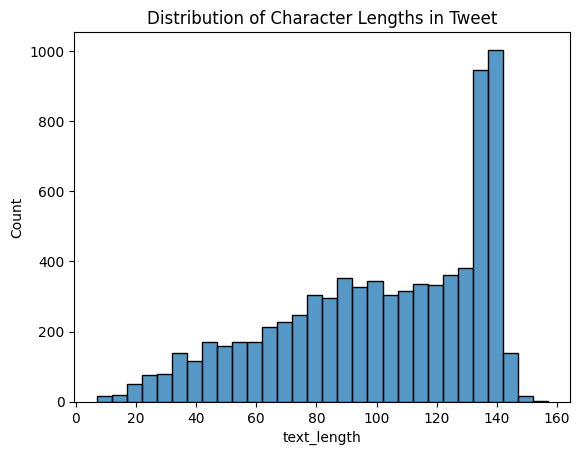

In [6]:
df['text_length'] = df['text'].apply(len)
sns.histplot(df['text_length'], bins=30)
plt.title('Distribution of Character Lengths in Tweet')
plt.show()

From visual inspection of the data changes will be made:
* The Tweets will need to be processed to remove special characters. 
* The keyword will not be used for training as, from the example given in the Kaggle introduction, it does not necessairily indicate a disaster. 

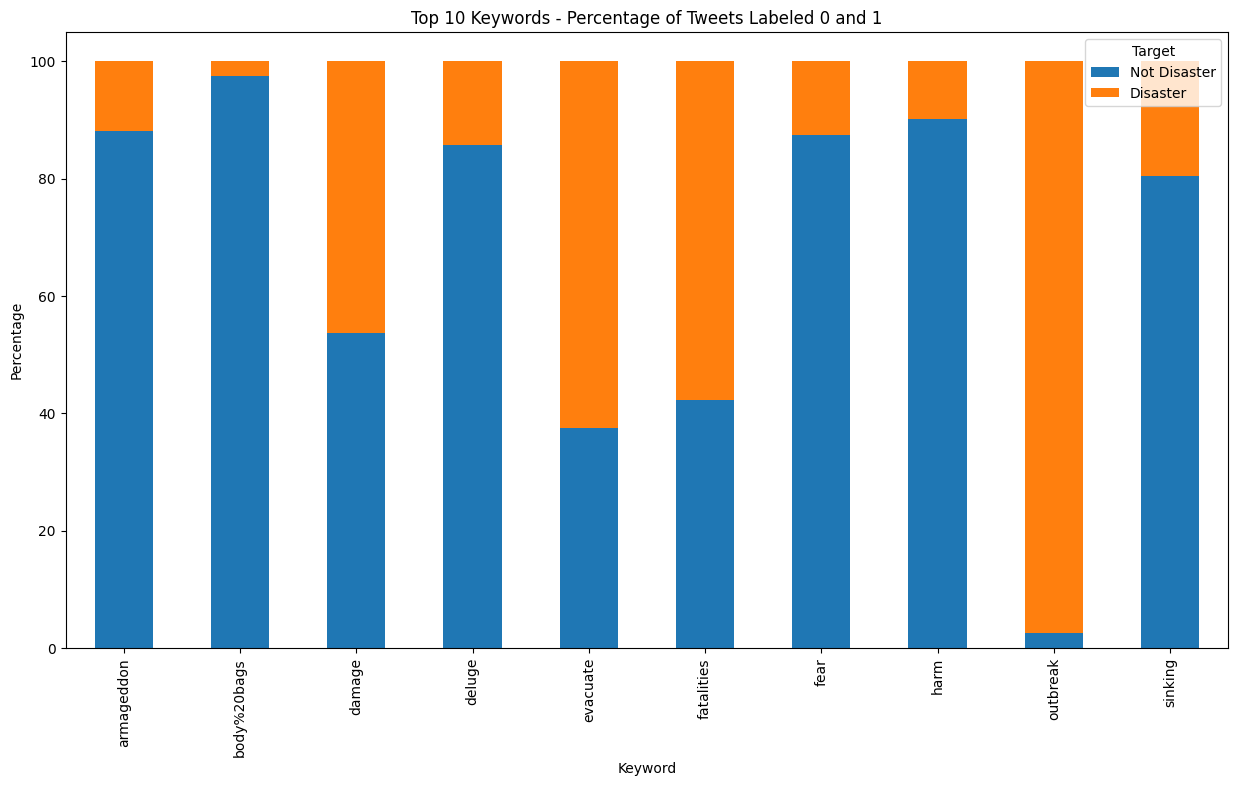

In [7]:
# Load the dataset
filepath = r'C:\Users\josea\OneDrive\Desktop\NLPDisasterTweets\train.csv'
df = pd.read_csv(filepath)


# Calculate the total count of tweets for each keyword
keyword_counts = df['keyword'].value_counts()

# Select the top n most frequent keywords, n=10 
top_n_keywords = keyword_counts.head(10).index

# Filter the DataFrame for the top N keywords
df_top_n = df[df['keyword'].isin(top_n_keywords)]

# Calculate the percentage of tweets with each keyword for each target label
keyword_percentage_by_target = df_top_n.groupby(['keyword', 'target']).size().unstack(fill_value=0).div(df_top_n['keyword'].value_counts(), axis=0) * 100

# Plot the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
keyword_percentage_by_target.plot(kind='bar', stacked=True, ax=ax)
ax.set_title(f'Top {len(top_n_keywords)} Keywords - Percentage of Tweets Labeled 0 and 1')
ax.set_ylabel('Percentage')
ax.set_xlabel('Keyword')
ax.legend(title='Target', labels=['Not Disaster', 'Disaster'])
plt.show()

We also check to see if the keyword is correlated to whether there was a disaster or not. Analyzing different keywords, this column was removed in training the model as there were many without correlation. As a future project, this may be considered and enhanced by including phrases.

# Data Cleaning

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


From our visual inspection in the EDA, there are several preprocessing steps that should be taken to improve the performance of the model:

1. Cleaning the text. We may want to remove URLs, mentions, punctuation, and convert the text to lowercase. This step is crucial as Tweets are unstructured data. URLs do not contain any meaningful information in our case, expecially since our goal is in analyzing the Tweet itsself. This can potentially cause issues if we perform tokenization and the URL contains some sort of phrase that the model understand to be meaningful, but contains no useful data. Similarly, mentions may be diverse and introduce many unique tokens to the dataset. Similarly, as we want to preserve as many tokenizations as possible, punctuation is removed and all words are cast to lowercase. 

In [9]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

df['text'] = df['text'].apply(clean_text)


2. Tokenize the text, remove stopwords, and lemmatization. This step will decrease the vocabulary size, reduce noise, and standardize our text.



In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josea\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we can visually view some of the text to see the changes that have been made:

In [11]:
# Load the dataset again
df_original = pd.read_csv(train_dataset)
df['original_text'] = df_original['text']

# Apply the preprocessing on the 'text' column
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(preprocess_text)

# Display some examples
sample_data = df[['original_text', 'text']].sample(10)  # Get a random sample of 10 rows
for index, row in sample_data.iterrows():
    print(f"Original Text: {row['original_text']}")
    print(f"Processed Text: {row['text']}\n")



Original Text: 1 of the major reason of suicide bombing is the absence of sexual interactions.
Processed Text: 1 major reason suicide bombing absence sexual interaction

Original Text: Jay and alexis broke up there goes all your faith and goals people... evacuate yourself
Processed Text: jay alexis broke go faith goal people evacuate

Original Text: VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... http://t.co/GEU4H46CsZ
Processed Text: video picking body water rescuer searching hundred migrant mediterran

Original Text: aggressif is so bloody aggressive
Processed Text: aggressif bloody aggressive

Original Text: @FEVWarrior -with the screeching siren accompanying it just before he walked out.
Processed Text: screeching siren accompanying walked

Original Text: Tennessee lesbian couple faked hate crime and destroyed own home with arsonÛ_ http://t.co/10mUEY8PXJ #Lesbian
Processed Text: tennessee lesbian couple faked hate c

# Model

We will create a train-test split with the training data to evaluate the performance of the model. 

We will utilize a simple RNN with LSTM cells for the task. 

In this model, we create an EmbeddingBag Layer that transforms the sparse count vectorized input into dense embeddings. We will compute the mean of the embeddings for a given sequence. This is done to take advantage of the sequentual nature of text. 

The LSTM layer will enable the model to remember long-term dependencies in the data. 

We will then pass the sequence through a linear layer to map the LSTM outputs to the desired output size and use a sigmoid activation size to output between 0 and 1, as this is a binary classification problem. 

There are several hyperparameters used:

* Input Size: This is determined by the shape of the training data. As we saw earlier in our EDA, there is a variety of Tweet sizes and we do not want the model to ignore this. 
* Hidden Size: The number of features in the hidden state. This determines the capacity of the LSTM. I chose a moderate value for this hyperparameter. While a higher value may capture more complex patterns, it may also overfit the data. 
* Learning rate: Several learning rates were tested to start with and I incoproate an Optimizer, Adam, to adjust this as the model is trained.  
* Number of epochs: Based on the performance over several different epoch numbers, the final submission was bested on the best generalization to the test data. 

Training: 
* BCELoss was chosen as this is a Binary classification task so a binary cross entropy loss was ideal for this task. 
* Optimizer: Adam is an adaptive learning rate optimizer that is known for being effective and requiring less manual tuning of the learning rate. 
* Training Loop: We perform a forward pass with the training data, compute the loss, perform backpropagation, and update the model's weights. 

Evaluation: We Evaluate the model's performance on the test split by checking how many predictions (rounded to 0 or 1 using a 0.5 threshhold) match the label. 

** Comparison to other models **

There were other models that would be adequate to perform the task. 

* Feedforward Neural Networks have been shown to be effective in this type of text classification task. However, it is less suitable for sequential data. Given the length of the Tweets, I did not elect to use this model.
* CNN: CNNs have been used for ssentence classification tasks. However, they tend to perform better when the text is shorter. Given the variety of lengths of the Tweets, I did not elect to use this model. 
* Transformer Models: While a model like BERT is state-of-the-art for many NLP tasks, it is computationally expensive to use. 



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pandas as pd
import re

# Load the dataset
filepath = r'C:\Users\josea\OneDrive\Desktop\NLPDisasterTweets\train.csv'
df = pd.read_csv(filepath)

# Data Cleaning and Preprocessing
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub('[^A-Za-z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['target'], test_size=0.2, random_state=42)

# Tokenization and Vectorization using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define an RNN model using LSTM
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_p=0.5):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = self.dropout(lstm_out[:, -1, :])
        x = self.fc(lstm_out)
        x = self.sigmoid(x)
        return x



# Instantiate the RNN model with more hidden units and dropout
input_size = X_train_tensor.shape[1]
hidden_size = 128
output_size = 1
num_layers = 1
dropout_p = 0.5

rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers, dropout_p).float()

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Train the RNN model
num_epochs = 20
batch_size = 64
train_dataset = TensorDataset(X_train_tensor.float(), y_train_tensor.view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    rnn_model.train()
    epoch_losses = []
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()

        # Convert sparse gradients to dense before optimizer step
        for param in rnn_model.parameters():
            if param.grad is not None:
                param.grad = param.grad.to_dense()

        optimizer.step()
        epoch_losses.append(loss.item())

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    
    scheduler.step(avg_epoch_loss)  # Update learning rate based on the average loss for this epoch

# Evaluate the RNN model on the test set
rnn_model.eval()
with torch.no_grad():
    test_outputs = rnn_model(X_test_tensor.float())
    test_predictions = (test_outputs >= 0.5).float()

accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())
print(f'Accuracy on the test set: {accuracy:.4f}')


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/20], Loss: 0.6744
Epoch [2/20], Loss: 0.5893
Epoch [3/20], Loss: 0.4328
Epoch [4/20], Loss: 0.3471
Epoch [5/20], Loss: 0.2995
Epoch [6/20], Loss: 0.2691
Epoch [7/20], Loss: 0.2421
Epoch [8/20], Loss: 0.2198
Epoch [9/20], Loss: 0.1993
Epoch [10/20], Loss: 0.1840
Epoch [11/20], Loss: 0.1676
Epoch [12/20], Loss: 0.1608
Epoch [13/20], Loss: 0.1412
Epoch [14/20], Loss: 0.1347
Epoch [15/20], Loss: 0.1251
Epoch [16/20], Loss: 0.1166
Epoch [17/20], Loss: 0.1110
Epoch [18/20], Loss: 0.1043
Epoch [19/20], Loss: 0.0997
Epoch [20/20], Loss: 0.0948
Accuracy on the test set: 0.7426


In [22]:
# List of hyperparameters
learning_rates = [0.001, 0.01]
hidden_sizes = [32, 64]
lstm_layers = [1, 2]

results = []

# Loop over hyperparameter grid
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for num_layers in lstm_layers:
            
            rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers).float()  # ensure the model is float
            criterion = nn.BCELoss()
            optimizer = optim.Adam(rnn_model.parameters(), lr=lr)
            
            # Train model
            rnn_model.train()
            optimizer.zero_grad()
            outputs = rnn_model(X_train_tensor.float())  # ensure input is float
            loss = criterion(outputs, y_train_tensor.view(-1, 1))
            loss.backward()
            for param in rnn_model.parameters():
                if param.grad is not None:
                    param.grad = param.grad.to_dense()
            optimizer.step()
            
            # Evaluate model
            rnn_model.eval()
            with torch.no_grad():
                test_outputs = rnn_model(X_test_tensor.float())  # ensure input is float
                test_predictions = (test_outputs >= 0.5).float()
            accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())
            
            results.append((lr, hidden_size, num_layers, accuracy))

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["Learning Rate", "Hidden Size", "LSTM Layers", "Test Accuracy"])
print(df_results)


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option a

   Learning Rate  Hidden Size  LSTM Layers  Test Accuracy
0          0.001           32            1       0.573867
1          0.001           32            2       0.573867
2          0.001           64            1       0.426133
3          0.001           64            2       0.573867
4          0.010           32            1       0.426133
5          0.010           32            2       0.573867
6          0.010           64            1       0.573867
7          0.010           64            2       0.573867


# Model Performance & Hyperparameter Tuning

We can inspect the output of our hyperparameter table to inspect the effects of hyperparameter tuning. 

In [23]:
print(df_results)


   Learning Rate  Hidden Size  LSTM Layers  Test Accuracy
0          0.001           32            1       0.573867
1          0.001           32            2       0.573867
2          0.001           64            1       0.426133
3          0.001           64            2       0.573867
4          0.010           32            1       0.426133
5          0.010           32            2       0.573867
6          0.010           64            1       0.573867
7          0.010           64            2       0.573867


We test several different learning rates, hidden sizes LSTM layers, to get the test accuracy. As we can see, the initial learning rate does not have a large influence (if any) on our results. This is because we are using an Optimizer, so while iterating over several epochs the initial learning rate is not very important, as long as it is within reasonable limits. The hidden size and LSTM layer were modified and did influence the model performance. Several different iterations were tested, and the best results were used. I hypothessize the hidden size and LSTM layer ultimately performed better because of the tokenization that was performed on the text. With the modifications we made, there is significant improvement by including a higher hidden size. 

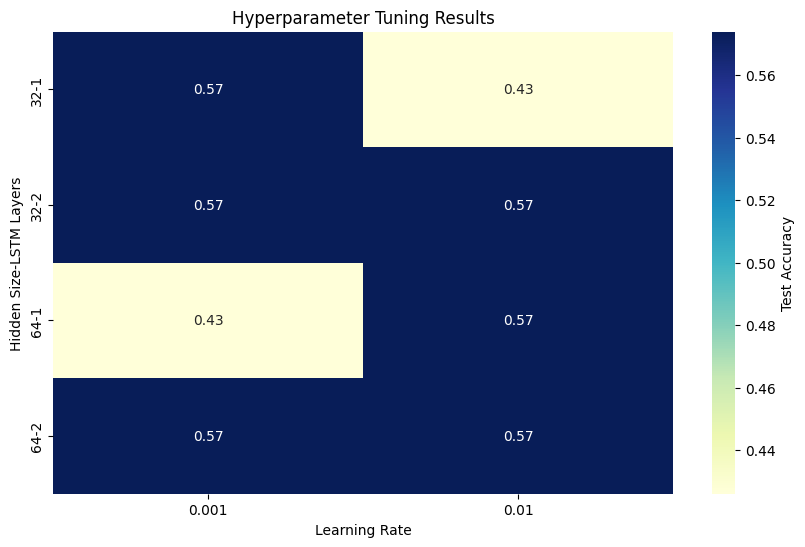

In [24]:
import seaborn as sns

# Pivot the results DataFrame for heatmap
pivot_results = df_results.pivot_table(index=["Hidden Size", "LSTM Layers"], 
                                       columns="Learning Rate", 
                                       values="Test Accuracy")

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot_results, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Test Accuracy'})
plt.title("Hyperparameter Tuning Results")
plt.show()


In [ ]:

# Load the test data
test_filepath = r'C:\Users\josea\OneDrive\Desktop\NLPDisasterTweets\test.csv'
test_df = pd.read_csv(test_filepath)

# Preprocess the test data (assuming you have a clean_text function defined)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Tokenization and Vectorization
X_test_vectorized = vectorizer.transform(test_df['cleaned_text'])
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)

# Model Inference
rnn_model.eval()
with torch.no_grad():
    test_outputs = rnn_model(X_test_tensor.long())
    test_predictions = (test_outputs >= 0.5).float()

# Create Submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions.numpy().flatten()  # Assuming 'target' is the column name for predictions
})

# Export to CSV
submission_filepath = r'C:\Users\josea\OneDrive\Desktop\NLPDisasterTweets\submission.csv'
submission_df.to_csv(submission_filepath, index=False)

With an accuracy score of 0.74 (in the final submission), the model performs reasonably well. 

Having completed the project, there are several steps that could be attempted to enhance the results:
* Supplement the training data with a larger dataset. The dataset that we use is fairly straightforward and other Tweet datasets could be used to enhance our dataset. 
* Add more data preprocessing. Given the limited size of our dataset, a visual inspection of the data could have been performed and extracted key disaster related keywords. While this may have improved the performance on this particular dataset, it may not have generalized as well if the model were tested over a large amoutn of real-world data. 
* Create a new column for phrases that commonly appear in the dataset.

The model performed reasonably well. However, there are enhancements that could be made to improve the performannce of the model. 